In [8]:
!pip install arviz

     |████████████████████████████████| 1.5MB 4.6MB/s 
     |████████████████████████████████| 4.1MB 28.7MB/s 
     |████████████████████████████████| 327kB 43.8MB/s 


In [9]:
!pip install pymc3==3.8


     |████████████████████████████████| 911kB 4.9MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [2]:
# !pip install pymc3
import theano
from theano import tensor as tt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from theano import shared
from collections import OrderedDict
from time import time
import pymc3 as pm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
import bs4 as bs
import urllib.request
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
import pystan

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## PyStan

In [0]:
sns.set()  # Nice plot aesthetic
np.random.seed(101)

model = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    alpha ~ normal(alpha, 3);
    y ~ normal(alpha + beta * x, sigma);
}
"""

In [0]:
# Parameters to be inferred
alpha = 4.0
beta = 0.5
sigma = 1.0

# Generate and plot data
x = 10 * np.random.rand(100)
y = alpha + beta * x
y = np.random.normal(y, scale=sigma)

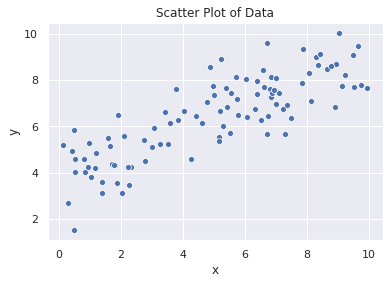

In [0]:
fig, ax = plt.subplots()
sns.scatterplot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot of Data')
fig.show()

In [0]:
my_data = {'N': len(x), 'x':x, 'y':y}

# compile the model
sm = pystan.StanModel(model_code = model)

# Train the model and generate samples
fit = sm.sampling(data=my_data, iter=1000, chains=4, warmup=500,
                 thin=1, seed=101)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5dac76512503e16d165a1650e73d6591 NOW.


In [0]:
fit

Inference for Stan model: anon_model_5dac76512503e16d165a1650e73d6591.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   3.85  6.3e-3   0.19   3.47   3.73   3.85   3.98   4.22    941    1.0
beta    0.52  1.1e-3   0.03   0.45    0.5   0.52   0.54   0.59    949    1.0
sigma   1.01  2.1e-3   0.07   0.87   0.96    1.0   1.05   1.16   1195    1.0
lp__  -50.62    0.04   1.21 -53.75 -51.14 -50.31 -49.76 -49.26    739   1.01

Samples were drawn using NUTS at Fri Apr 17 20:28:01 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [0]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

alpha_mean, beta_mean = df['mean']['alpha'], df['mean']['beta']

# Extracting traces
alpha = fit['alpha']
beta = fit['beta']
sigma = fit['sigma']
lp = fit['lp__']

In [0]:
df

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,3.851095,0.006284,0.192745,3.465029,3.726258,3.848893,3.984271,4.224171,940.701224,0.999217
beta,0.518369,0.001097,0.033787,0.452315,0.496904,0.518582,0.539565,0.587794,948.611362,0.999069
sigma,1.007607,0.002127,0.073528,0.870975,0.958357,1.002887,1.054083,1.159258,1194.621102,0.999689
lp__,-50.623869,0.044570,1.211308,-53.754838,-51.141953,-50.313697,-49.756458,-49.262103,738.640284,1.005184


In [0]:
def plot_trace(param, param_name='parameter'):
  """Plot the trace and posterior of a parameter."""
  
  # Summary statistics
  mean = np.mean(param)
  median = np.median(param)
  cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
  
  # Plotting
  plt.subplot(2,1,1)
  plt.plot(param)
  plt.xlabel('samples')
  plt.ylabel(param_name)
  plt.axhline(mean, color='r', lw=2, linestyle='--')
  plt.axhline(median, color='c', lw=2, linestyle='--')
  plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
  plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
  plt.title('Trace and Posterior Distribution for {}'.format(param_name))

  plt.subplot(2,1,2)
  plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
  plt.xlabel(param_name)
  plt.ylabel('density')
  plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
  plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
  plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
  plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
  plt.gcf().tight_layout()
  plt.legend()

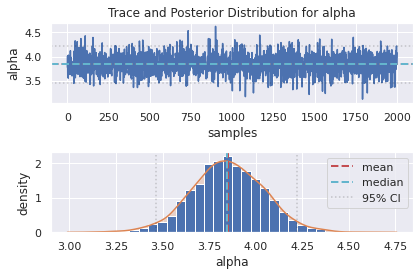

In [0]:
plot_trace(alpha, 'alpha')

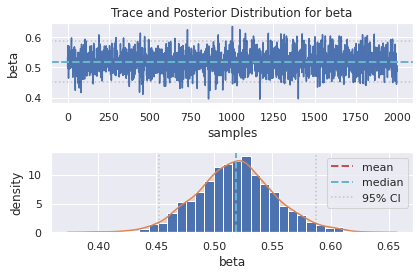

In [0]:
plot_trace(beta, 'beta')

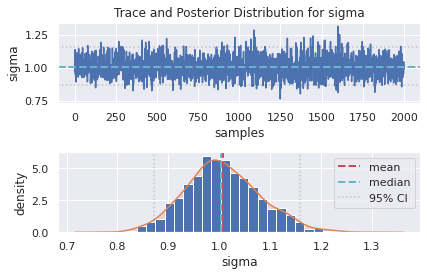

In [0]:
plot_trace(sigma, 'sigma')

## PyMC3

### Dirichlet Process

### Stick Breaking

In [0]:
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

In [0]:
dp = pm.Model()

with dp:
    alpha = 10*pm.Gamma('alpha', 1, 1)
    beta = pm.Beta('beta', 1, alpha, shape=5)
    pi = pm.Deterministic('pi', stick_breaking(beta))
    
with dp:
    trace = pm.sample(8, tune=10, init='advi', random_seed=1)

Only 8 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average Loss = 1.4419:   3%|▎         | 5609/200000 [00:02<01:35, 2025.29it/s]
Convergence achieved at 5700
INFO:pymc3.variational.inference:Convergence achieved at 5700
Interrupted at 5,699 [2%]: Average Loss = 1.7765
INFO:pymc3.variational.inference:Interrupted at 5,699 [2%]: Average Loss = 1.7765
Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]
INFO:pymc3:NUTS: [beta, alpha]
100%|██████████| 18/18 [00:00<00:00, 156.46it/s]
/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:464: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


In [0]:
trace['pi']

array([[0.13274967, 0.12561324, 0.01227707, 0.0357046 , 0.09780244],
       [0.04239857, 0.0318148 , 0.02267302, 0.0388569 , 0.03959407],
       [0.03557368, 0.04192122, 0.04219514, 0.07366091, 0.03051061],
       [0.12443832, 0.04740536, 0.1161733 , 0.01378992, 0.01817424],
       [0.10603288, 0.06367163, 0.15468667, 0.02723038, 0.02625412],
       [0.03634361, 0.21036338, 0.00688813, 0.02377619, 0.24555332],
       [0.05666744, 0.09550916, 0.00874794, 0.02322937, 0.02977894],
       [0.09398819, 0.03961489, 0.0053174 , 0.06839612, 0.05064873],
       [0.36001807, 0.39791261, 0.22232797, 0.00641197, 0.00276174],
       [0.4933286 , 0.03948072, 0.22180328, 0.14872835, 0.06007426],
       [0.54675667, 0.05396938, 0.06724831, 0.23577807, 0.06367625],
       [0.06012741, 0.17189407, 0.12201372, 0.02177899, 0.02483718],
       [0.07996672, 0.00713809, 0.16159708, 0.08564732, 0.00293429],
       [0.12005211, 0.05844851, 0.2980742 , 0.10084871, 0.00068063],
       [0.26689952, 0.05748213, 0.

In [0]:
trace['alpha']

array([0.7744137 , 2.99358406, 1.45655111, 1.76699217, 0.77876762,
       1.22759186, 0.95605505, 2.46759734, 0.2727915 , 0.06258292,
       0.12690358, 1.58070904, 0.52282028, 0.5462796 , 0.3484625 ,
       0.26002146])

## DP Mixture Model with MCMC and ADVI

In [0]:
# import some data to play with
iris = datasets.load_iris()
# iris['data']

In [0]:
# faith = pd.read_csv('faithful.csv')
# faith.waiting.values

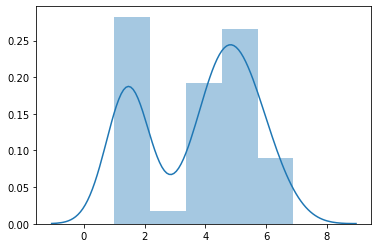

In [0]:
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

# data = faith.waiting.values
data = iris['data'][:,2]
import seaborn as sns
sns.distplot(data)

In [0]:
K = 30

with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))

    tau = pm.Gamma('tau', 1., 1., shape=K)
    lambda_ = pm.Uniform('lambda', 0, 5, shape=K)
    
    mu = pm.Normal('mu', 0, tau=lambda_ * tau, shape=K)
    
    obs = pm.NormalMixture('obs', w, mu, tau=lambda_ * tau,
                           observed=data)

### MCMC

In [0]:
SEED = 1
with model:
    step_metro = pm.step_methods.metropolis.Metropolis()
    step_hmc = pm.step_methods.hmc.hmc.HamiltonianMC()
    step_nuts = pm.step_methods.hmc.nuts.NUTS()
    
    step = step_nuts
    trace = pm.sample(200, step, random_seed=SEED, init='advi')

Only 200 samples in chain.
Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
NUTS: [mu, lambda, tau, beta, alpha]
INFO:pymc3:NUTS: [mu, lambda, tau, beta, alpha]
Sampling chain 1, 14 divergences: 100%|██████████| 700/700 [00:20<00:00, 33.38it/s]
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


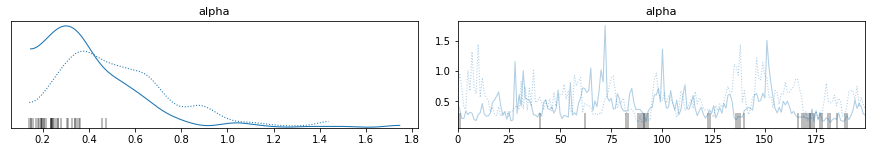

In [0]:
pm.traceplot(trace, var_names=['alpha']);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc030946a58>,
      dtype=object)

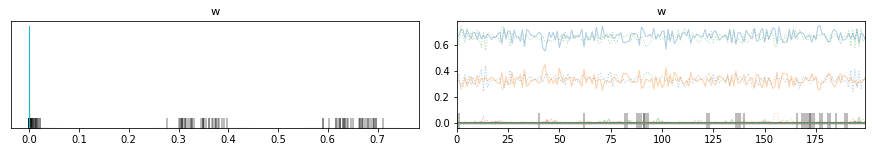

In [0]:
pm.traceplot(trace, var_names=['w'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc03df7f630>,
      dtype=object)

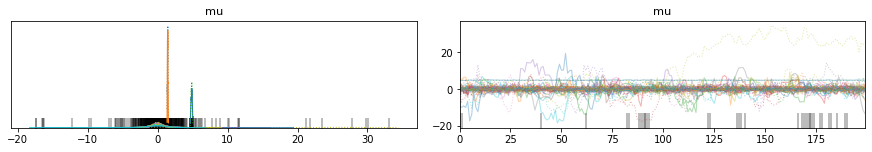

In [0]:
pm.traceplot(trace, var_names=['mu'])

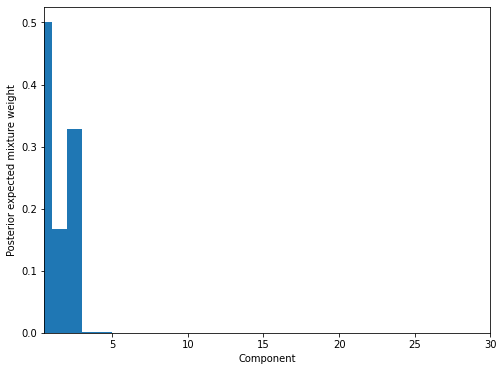

In [0]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(K) + 1

ax.bar(plot_w - 0.5, trace['w'].mean(axis=0), width=1., lw=0);

ax.set_xlim(0.5, K);
ax.set_xlabel('Component');

ax.set_ylabel('Posterior expected mixture weight');

### ADVI

In [0]:
η = .1
s = shared(η)
def reduce_rate(a, h, i):
    s.set_value(η/((i/minibatch_size)+1)**.7)

# we have sparse dataset. It's better to have dence batch so that all words accure there
minibatch_size = 128

# defining minibatch
# doc_t_minibatch = pm.Minibatch(docs_tr.toarray(), minibatch_size)
# doc_t = shared(docs_tr.toarray()[:minibatch_size])

# local_RVs = OrderedDict([alpha, beta, mu])
    
with model:
#     approx = pm.MeanField(local_rv=local_RVs)
    approx = pm.MeanField()
    approx.scale_cost_to_minibatch = False
    inference = pm.KLqp(approx)
    inference.fit(10000, callbacks=[reduce_rate], 
              obj_optimizer=pm.sgd(learning_rate=s))
#               more_obj_params=encoder_params, 
#               total_grad_norm_constraint=200,
#               more_replacements={doc_t: doc_t_minibatch})
                  

In [0]:
with model:
    %time approx = pm.fit(n=4500, obj_optimizer=pm.adagrad(learning_rate=1e-1))

In [0]:
means = approx.bij.rmap(approx.mean.eval())
cov = approx.cov.eval()
sds = approx.bij.rmap(np.diag(cov)**.5)

In [0]:
means.keys()

In [0]:
plt.plot(means['mu'])

In [0]:
plt.plot(means['tau_log__'])

In [0]:
plt.plot(cov)

## Multivariate Normal Mixture HDP

### Univariate Normal HDP

150
          x1         x2 cat
0   0.765312   0.933845   1
1   1.692529   0.156062   1
2   1.419355   2.677968   1
3   0.741160   0.525895   1
4   0.095291   0.064659   1
..       ...        ...  ..
95 -7.864878  18.350865   2
96 -8.662661  18.398604   2
97 -6.242953  20.846134   2
98 -7.820191  20.586978   2
99 -6.874655  23.080808   2

[100 rows x 3 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: covariance is not positive-semidefinite.


150

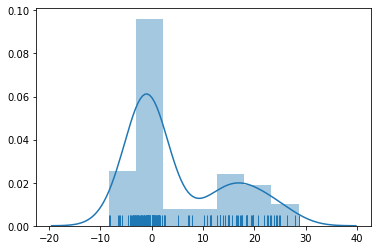

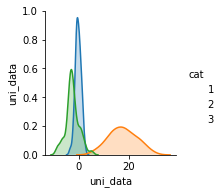

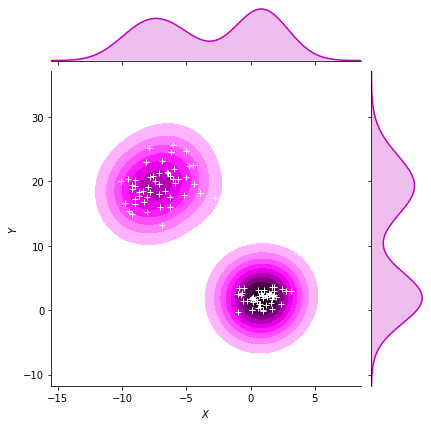

In [85]:
from sklearn import datasets
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

# import some data to play with
iris = datasets.load_iris()
iris['data']

# univariate data
# data = faith.waiting.values
# data = iris['data'][:,1]
mu_1, sigma_1 = 0, 1.5 # mean and standard deviation
mu_2, sigma_2 = 18, 5
mu_3, sigma_3 = -3, 3
# mu_4, simga_4 = 
# mu_5, simga_5 =
s_1 = list(np.random.normal(mu_1, sigma_1, 50))
s_2 = list(np.random.normal(mu_2, sigma_2, 50))
s_3 = list(np.random.normal(mu_3, sigma_3, 50))

uni_data = s_1 + s_2 + s_3
sns.distplot(uni_data, rug=True)
print(len(uni_data))

uni_data_cat = ['1' for i in range(50)] + ['2' for i in range(50)] +['3' for i in range(50)]
uni_data_frame = pd.DataFrame({'uni_data': uni_data, 'cat': uni_data_cat})
# print(uni_data_frame)
sns.pairplot(uni_data_frame,hue = 'cat')


# define dataset
data = uni_data

dim = np.shape(data)[0]
dim

In [0]:
SEED = 1
K_topics = 50
M_topics_per_doc = 20
atoms = np.random.normal(0, .01, K_topics)

# Custom distribution in PyMC3
def logp_G0(atoms, w, value):
    idx = np.where(atoms == value)[0]   # Example return value: (array([], dtype=int32),)
    if len(idx) == 0:
      return 0
    return log(w[idx[0]])

# def random_G)()

with pm.Model() as hdp_model:
    
    # Topics DP
    alpha_0 = pm.Gamma('alpha_0', 1., 1.)
    beta_0 = pm.Beta('beta_0', 1., alpha_0, shape=K_topics)
    w_0 = pm.Deterministic('w_0', stick_breaking(beta_0))

    # Get samples from normal 
    tau_0 = pm.Gamma('tau_0', 1., 1., shape=K_topics)
    lambda_0 = pm.Uniform('lambda_0', 0, 5, shape=K_topics)
    mu_0 = pm.Normal('mu_0', np.zeros(K_topics), tau=1, shape=K_topics)
    # atoms = pm.Normal('atoms', np.zeros(K_topics), tau=tau_0*lambda_0, shape=K_topics)  # Should this be a RV?
    atoms = pm.Normal('atoms', mu_0, tau=tau_0*lambda_0, shape=K_topics)  # Should this be a RV?

    # Need to get samples from G0 --> these become the mu's for the final dist
    # sample_theta = np.random.choice(atoms, M_topics_per_doc, p=w_0)
    # https://discourse.pymc.io/t/multivariatre-categorical-variable-with-different-values/1008/2
    tmp = pm.Categorical('tmp', w_0, shape=M_topics_per_doc)
    sample_theta = pm.Deterministic('shared_theta', atoms[tmp])

    # Want G0 to be atoms in second level of HDP
    # G0 = pm.DensityDist('G0', logp_G0, observed={'atoms':atoms, 'w':w_0, 'value': sample_theta})
    
    # mu = pm.Normal('mu', 0, tau=lambda_ * tau, shape=K)   # I don't think we want this to be a RV
    
    # obs = pm.NormalMixture('obs', w, mu, tau=lambda_ * tau,
    #                        observed=data)

    tau_j = pm.Gamma('tau_j', 1., 1., shape=M_topics_per_doc)
    lambda_j = pm.Uniform('lambda_j', 0, 5, shape=M_topics_per_doc)
    # Doc DP
    alpha_j = pm.Gamma('alpha_j', 1., 1.)   # We can choose to use the same alpha_0 as above
    beta_j = pm.Beta('beta_j', 1., alpha_j, shape=M_topics_per_doc)    # Same comment as above
    w_j = pm.Deterministic('w_j', stick_breaking(beta_j))

    obs = pm.NormalMixture('obs', w_j, sample_theta, tau=lambda_j * tau_j, observed=data)
    
    # cov = np.array([[1., 0.5], [0.5, 2]])
    # mu = np.zeros(2)
    # vals = pm.MvNormal('vals', mu=mu, cov=cov, shape=(5, 2), observed=data)

In [87]:
print(hdp_model.basic_RVs)

[alpha_0_log__, beta_0_logodds__, tau_0_log__, lambda_0_interval__, mu_0, atoms, tmp, tau_j_log__, lambda_j_interval__, alpha_j_log__, beta_j_logodds__, obs]


In [88]:
with hdp_model:
    step_metro = pm.step_methods.metropolis.Metropolis()
    step_hmc = pm.step_methods.hmc.hmc.HamiltonianMC()
    step_nuts = pm.step_methods.hmc.nuts.NUTS()

    step = step_nuts
    trace = pm.sample(5000, step, random_seed=SEED, init='advi')#, exception_verbosity='high')

Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
CompoundStep
INFO:pymc3:CompoundStep
>NUTS: [beta_j, alpha_j, lambda_j, tau_j, atoms, mu_0, lambda_0, tau_0, beta_0, alpha_0]
INFO:pymc3:>NUTS: [beta_j, alpha_j, lambda_j, tau_j, atoms, mu_0, lambda_0, tau_0, beta_0, alpha_0]
>CategoricalGibbsMetropolis: [tmp]
INFO:pymc3:>CategoricalGibbsMetropolis: [tmp]
Sampling chain 1, 4,999 divergences: 100%|██████████| 5500/5500 [00:52<00:00, 105.62it/s]
There were 2335 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2335 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7835 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 7835 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3951786260867121, but should be close to 0.8. Try to increase the number of tuning

In [0]:
# with hdp_model:
#     approx = pm.fit(n=4500, obj_optimizer=pm.adagrad(learning_rate=1e-1))

#### Traceplot for univariate hdp

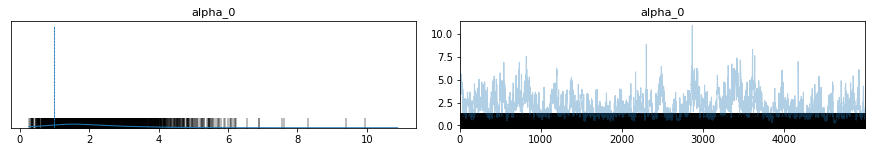

In [107]:
pm.traceplot(trace, var_names=['alpha_0']);

In [108]:
print(trace['alpha_0'].mean(0))

1.565986357343265


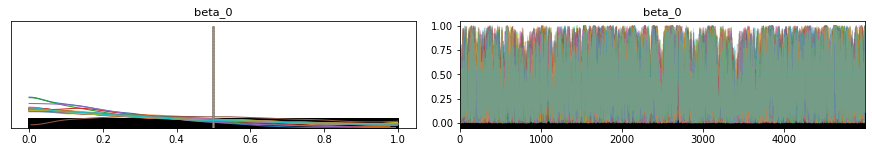

In [109]:
pm.traceplot(trace, var_names=['beta_0']);

In [110]:
print(trace['beta_0'].mean(0))

[0.35639298 0.4120944  0.37447379 0.39402022 0.37271448 0.49351636
 0.42588437 0.42317863 0.4291648  0.42817882 0.43145024 0.42845872
 0.4318672  0.4320984  0.42505094 0.4283208  0.42758024 0.42724208
 0.43143461 0.42462538 0.4276604  0.42773095 0.42516216 0.42878873
 0.42714668 0.43054041 0.4262964  0.42836304 0.43207046 0.42892506
 0.42476416 0.43372724 0.43022483 0.42455225 0.42892767 0.42422121
 0.42923493 0.43160491 0.42618618 0.42712584 0.42858302 0.42740714
 0.43102187 0.43084435 0.42934626 0.42941624 0.42912419 0.42721006
 0.43244012 0.42604064]


In [111]:
len(trace['beta_0'].mean(1))

10000

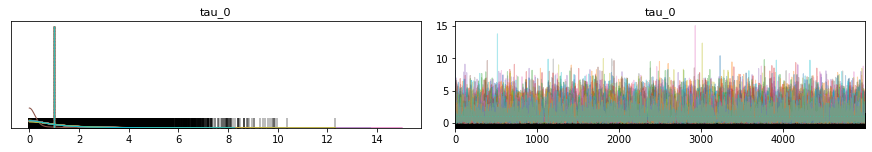

In [112]:
pm.traceplot(trace, var_names=['tau_0']);

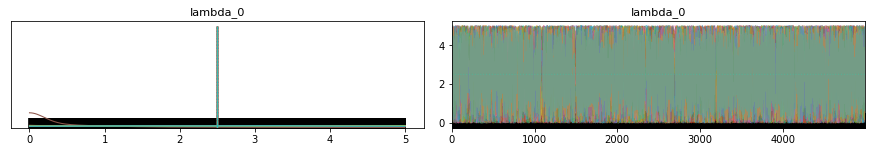

In [113]:
pm.traceplot(trace, var_names=['lambda_0']);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efcacc255f8>,
      dtype=object)

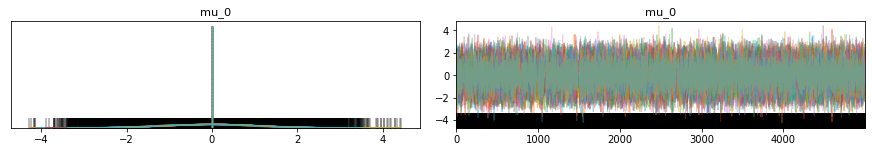

In [114]:
pm.traceplot(trace, var_names=['mu_0'])

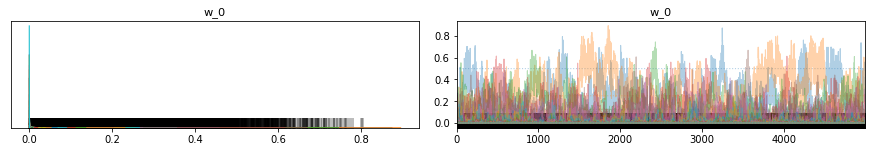

In [115]:
pm.traceplot(trace, var_names=['w_0']);

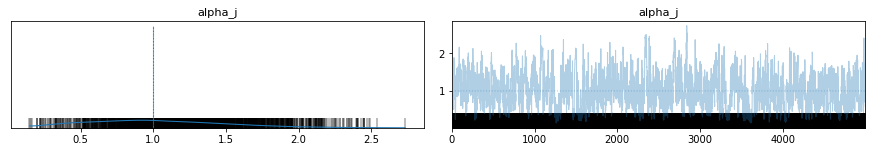

In [116]:
pm.traceplot(trace, var_names=['alpha_j']);

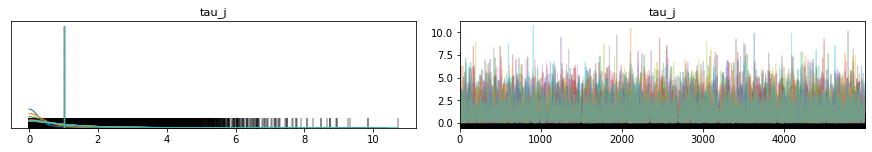

In [117]:
pm.traceplot(trace, var_names=['tau_j']);

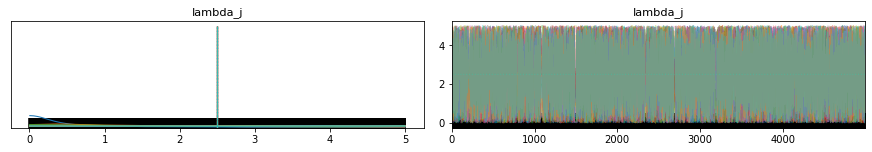

In [118]:
pm.traceplot(trace, var_names=['lambda_j']);

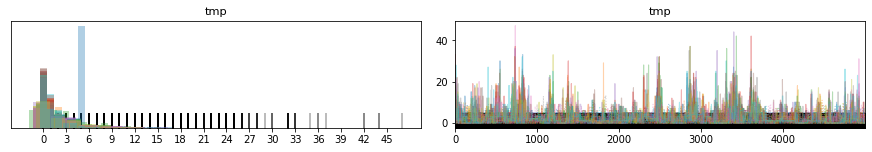

In [119]:
pm.traceplot(trace, var_names=['tmp']);

In [120]:
trace['tmp'].mean(0)

array([2.9202, 1.7253, 1.6235, 1.8165, 1.8222, 2.0267, 1.9497, 1.8137,
       1.9984, 1.8466, 1.9779, 1.7943, 1.7701, 2.041 , 1.7682, 1.939 ,
       1.7355, 1.803 , 1.8255, 1.8037])

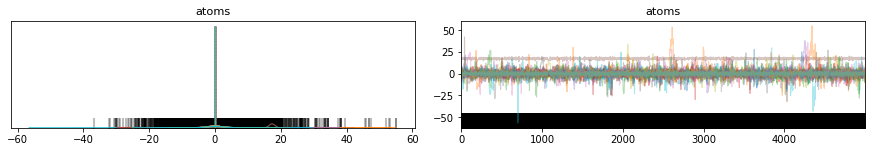

In [121]:
pm.traceplot(trace, var_names=['atoms']);

In [122]:
len(trace['atoms'].mean(0))

50

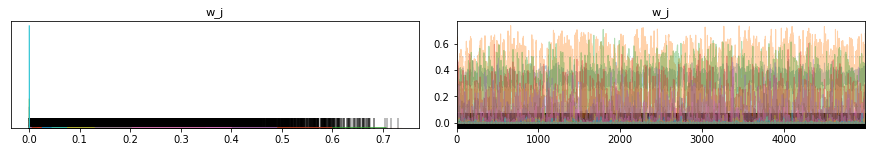

In [123]:
pm.traceplot(trace, var_names=['w_j']);

### Multivariate Normal HDP

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: covariance is not positive-semidefinite.
  import sys


          x1         x2 cat
0   1.111406   0.992654   1
1   2.525145   2.688007   1
2   1.099822   4.131434   1
3   1.504448   2.235174   1
4   0.651060   0.661774   1
..       ...        ...  ..
95 -9.823139  17.273174   2
96 -5.353608  18.101184   2
97 -6.015703  25.366898   2
98 -7.702816  22.891378   2
99 -5.912213  20.507380   2

[100 rows x 3 columns]


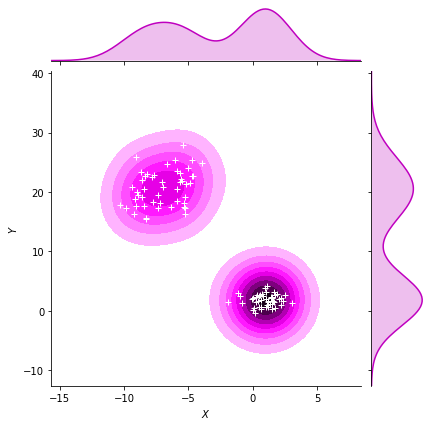

In [169]:
# multivariate data
dim = 2
mean1 = (1, 2)
mean2 = (-7, 20)
cov1 = [[1, 0], [0, 1]]
cov2 = [[0.7, 9.9], [4, 3.2]]
x1 = list(np.random.multivariate_normal(mean1, cov1, 50))
x2 = list(np.random.multivariate_normal(mean2, cov2, 50))
multi_data = x1 + x2

multi_data_cat = ['1' for i in range(50)] + ['2' for i in range(50)]

multi_data_frame = pd.DataFrame(multi_data)
multi_data_frame.columns = ['x1', 'x2']
multi_data_frame = pd.concat([multi_data_frame, pd.DataFrame({'cat': multi_data_cat})], axis=1)
print(multi_data_frame)

g = sns.jointplot(x="x1", y="x2", data=multi_data_frame, kind="kde", color="m")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$");

In [0]:
# mean1 = np.array([1, 2])
# mean2 = np.array([-7, 20])
# cov1 = np.array([[1, 0], [0, 1]])
# cov2 = np.array([[0.7, 9.9], [4, 3.2]])


# with pm.Model() as multivar_normal_mix:
#     component0 = pm.MvNormal('c0', mu=mean1, cov=cov1, shape=2)
#     component1 = pm.MvNormal('c1', mu=mean2, cov=cov2, shape=2)
#     w = pm.Beta('w', 1, 1)
#     mix = pm.Mixture('mix', w=[w, 1 - w], comp_dists=[component0.distribution, component1.distribution], 
#                      shape=2, observed = iris['data'][:,1:4])
#     # obs = pm.Normal('obs', mu=mix[0] * x + mix[1], sigma= 1, observed=multi_data_frame.loc[:, ['x1', 'x2']])

# with multivar_normal_mix:
    
#     step_nuts = pm.step_methods.hmc.nuts.NUTS()
#     step_metro = pm.step_methods.metropolis.Metropolis()

#     step = step_metro
#     trace_multivar = pm.sample(2000, step, random_seed=SEED, init='advi')

In [0]:
def MvNorm_HDP(data, K_topics, M_topics_per_doc, n_samples, mcmc): 

    dim = np.shape(data)[1]
    with pm.Model() as multivar_normal_hdp:
      # Topics DP
        alpha_0 = pm.Gamma('alpha_0', 1., 1.)
        beta_0 = pm.Beta('beta_0', 1., alpha_0, shape=K_topics)
        w_0 = pm.Deterministic('w_0', stick_breaking(beta_0))

        # Get samples from normal 
        # tau_0 = pm.Gamma('tau_0', 1., 1., shape=K_topics)
        # lambda_0 = pm.Uniform('lambda_0', 0, 5, shape=K_topics)

        mu_0 = pm.MvNormal('mu_0', np.zeros(dim), tau=cov0, shape=(K_topics, dim))
        # atoms = pm.Normal('atoms', np.zeros(K_topics), tau=tau_0*lambda_0, shape=K_topics)  # Should this be a RV?
        atoms = pm.MvNormal('atoms', mu_0, tau=cov0, shape=(K_topics, dim))  # Should this be a RV?

        tmp = pm.Categorical('tmp', w_0, shape=M_topics_per_doc)
        sample_theta = pm.Deterministic('shared_theta', atoms[tmp])

        # tau_j = pm.Gamma('tau_j', 1., 1., shape=M_topics_per_doc)
        # lambda_j = pm.Uniform('lambda_j', 0, 5, shape=M_topics_per_doc)

        # Doc DP
        alpha_j = pm.Gamma('alpha_j', 1., 1.)   # We can choose to use the same alpha_0 as above
        beta_j = pm.Beta('beta_j', 1., alpha_j, shape=M_topics_per_doc)    # Same comment as above
        w_j = pm.Deterministic('w_j', stick_breaking(beta_j))

        comp_dists_list = []
        for m in range(M_topics_per_doc):
          normal_m = pm.MvNormal('normal_'+str(m), sample_theta[m], tau=cov0, shape=dim)
          comp_dists_list.append(normal_m.distribution)

        obs = pm.Mixture('obs', w_j, comp_dists = comp_dists_list, shape = M_topics_per_doc, 
                        #  observed=iris['data'][:,1:3])
                        observed=data)


    with multivar_normal_hdp:
        step_nuts = pm.step_methods.hmc.nuts.NUTS()
        step_metro = pm.step_methods.metropolis.Metropolis()

        if mcmc == 'nuts':
          step = step_nuts
        elif mcmc == 'metro':
          step = step_metro
        trace_multivar = pm.sample(n_samples, step, random_seed=SEED, init='advi')
    return trace_multivar

In [0]:
SEED = 1
K_topics = 50
M_topics_per_doc = 20
atoms = np.random.normal(0, .01, K_topics)

dim = dim # dimension of word vectors

# for now I have assumed all covariance matrices to be identity matrix
# We need to add priors on this later
cov0 = np.array([[1, 0], [0, 1]])

data = multi_data_frame.iloc[:, :2]
n_samples = 2000

mcmc = 'nuts'

trace_multivar = MvNorm_HDP(data, K_topics, M_topics_per_doc, n_samples, mcmc)

In [213]:
print(multivar_normal_hdp.basic_RVs)

[alpha_0_log__, beta_0_logodds__, mu_0, atoms, tmp, alpha_j_log__, beta_j_logodds__, normal_0, normal_1, normal_2, normal_3, normal_4, normal_5, normal_6, normal_7, normal_8, normal_9, normal_10, normal_11, normal_12, normal_13, normal_14, normal_15, normal_16, normal_17, normal_18, normal_19, obs]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efc83719ef0>,
      dtype=object)

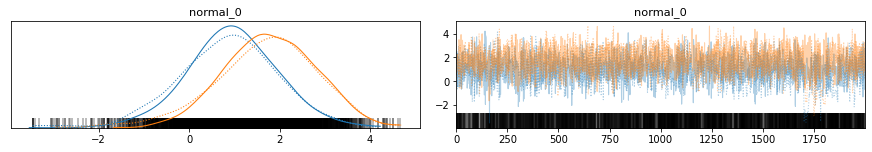

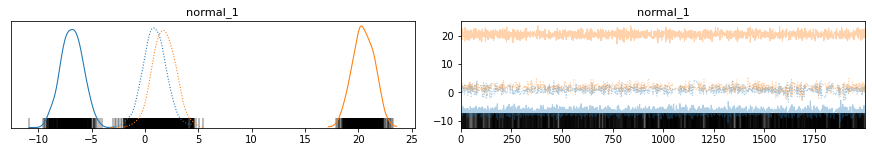

In [214]:
pm.traceplot(trace_multivar, var_names=['normal_0'])
pm.traceplot(trace_multivar, var_names=['normal_1'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efc7fcd7b38>,
      dtype=object)

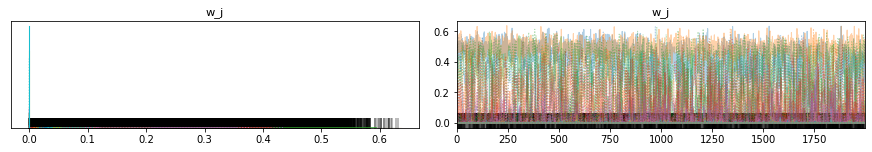

In [215]:
pm.traceplot(trace_multivar, var_names=['w_j'])

In [216]:
## means of clusters

print('w: ', trace_multivar['w_j'].mean(0))

for i in range(M_topics_per_doc):
  print('normal_'+str(i)+': ', trace_multivar['normal_'+str(i)].mean(0))


w:  [3.13549956e-01 3.45459575e-01 2.02905597e-01 8.57061946e-02
 2.51551462e-02 1.32938405e-02 7.12112333e-03 3.51106866e-03
 1.63584014e-03 8.03999545e-04 4.36564258e-04 2.01234810e-04
 1.04436996e-04 5.85548126e-05 2.35440958e-05 1.80804760e-05
 9.79780244e-06 2.85447365e-06 1.46513379e-06 6.08767231e-07]
normal_0:  [0.88602856 1.72835057]
normal_1:  [-2.99173074 11.10302784]
normal_2:  [-3.07197763 10.88690644]
normal_3:  [-3.13785604 10.74547338]
normal_4:  [0.70868029 1.33786428]
normal_5:  [0.65252009 1.2923961 ]
normal_6:  [0.6937975  1.37658355]
normal_7:  [-3.10389084 10.75468157]
normal_8:  [0.73632173 1.30752547]
normal_9:  [0.62110894 1.20200269]
normal_10:  [0.67150686 1.30790981]
normal_11:  [0.55156088 1.07366202]
normal_12:  [0.58454672 1.18058584]
normal_13:  [-3.11824755 10.76948035]
normal_14:  [-3.27087575 10.62678316]
normal_15:  [-3.1144231  10.79419099]
normal_16:  [-3.12504792 10.77491341]
normal_17:  [0.62656506 1.2338707 ]
normal_18:  [-3.12702996 10.79291913

## Text Data - word2vec embeddings

### Loading Data

In [4]:
# The number of words in the vocabulary
n_words = 50

print("Loading dataset...")
t0 = time()
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, 
                                max_features=n_words, 
                                # If not None, build a vocabulary that 
                                # only consider the top max_features 
                                # ordered by term frequency across the corpus.
                                stop_words='english')

t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
feature_names = tf_vectorizer.get_feature_names()
print("done in %0.3fs." % (time() - t0))

INFO:sklearn.datasets._twenty_newsgroups:Downloading 20news dataset. This may take a few minutes.
INFO:sklearn.datasets._twenty_newsgroups:Downloading dataset from https://ndownloader.figshare.com/files/5975967 (14 MB)


Loading dataset...
done in 10.925s.
Extracting tf features for LDA...
done in 1.593s.


In [5]:
tf.toarray()[0:5].shape

(5, 50)

In [6]:
tf.toarray().shape

(11314, 50)

In [7]:
data_samples[0:5]

["Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n",
 "\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap

In [8]:
len(feature_names)

50

In [9]:
feature_names

['10',
 'available',
 'ax',
 'believe',
 'bit',
 'com',
 'data',
 'did',
 'does',
 'don',
 'edu',
 'file',
 'god',
 'going',
 'good',
 'government',
 'information',
 'just',
 'key',
 'know',
 'like',
 'll',
 'make',
 'max',
 'need',
 'new',
 'number',
 'people',
 'point',
 'problem',
 'program',
 'really',
 'right',
 'said',
 'say',
 'space',
 'thanks',
 'things',
 'think',
 'time',
 'use',
 'used',
 'using',
 've',
 'want',
 'way',
 'windows',
 'work',
 'year',
 'years']

### Preprocessing

In [10]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
'aa,fsad' + 'fadsfa'

'aa,fsadfadsfa'

In [0]:
# Cleaing the text
processed_article = ''
for paragraph in data_samples:
    processed_article += paragraph
    processed_article += ' '

In [0]:
processed_article = re.sub('[^a-zA-Z]', ' ', processed_article )
processed_article = re.sub(r'\s+', ' ', processed_article)

# Preparing the dataset
all_sentences = nltk.sent_tokenize(processed_article)

all_words = [nltk.word_tokenize(sent) for sent in all_sentences]


# Removing Stop Words
from nltk.corpus import stopwords
for i in range(len(all_words)):
    all_words[i] = [w for w in all_words[i] if w not in stopwords.words('english')]
    

from gensim.models import Word2Vec

word2vec = Word2Vec(all_words, size=5, min_count=1)

In [0]:
vocabulary = word2vec.wv.vocab
print(vocabulary)

In [0]:
word2vec.wv['try'].shape

In [0]:
word2vec.wv['try']

In [0]:
word2vec.wv['try']

In [0]:
word_data = {}
for word in feature_names:
  try:
    word_data[word] = list(word2vec.wv[word])
  except:
    print(word)
word_data = pd.DataFrame(word_data).T
word_data

### Test on Word Data

In [0]:
SEED = 1
K_topics = 50
M_topics_per_doc = 20
atoms = np.random.normal(0, .01, K_topics)

dim = dim # dimension of word vectors
cov0 = np.zeros((5,5))
for i in range(5):
  cov0[i,i] = 1

data = word_data
n_samples = 2000

mcmc = 'nuts'

trace_word = MvNorm_HDP(data, K_topics, M_topics_per_doc, n_samples, mcmc)

In [0]:
print(multivar_normal_hdp.basic_RVs)